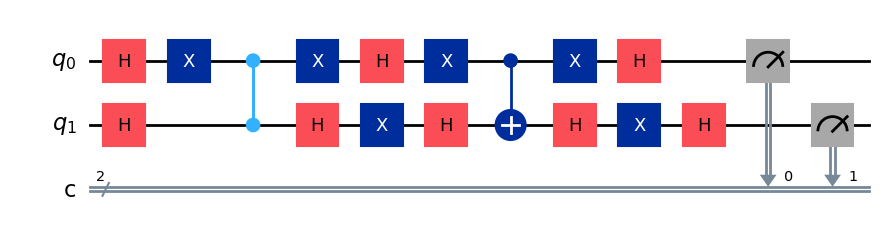

In [22]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

n_qubits = 2
grover_circuit = QuantumCircuit(n_qubits, n_qubits)
grover_circuit.h(range(n_qubits))
grover_circuit.x(0)       # X on qubit 0 to turn |01> into |00>
grover_circuit.cz(0, 1)   # Controlled-Z (flips phase if both are 1)
grover_circuit.x(0)

##
grover_circuit.h(range(n_qubits))
grover_circuit.x(range(n_qubits))
grover_circuit.h(1)       # Controlled-Z using H-CX-H
grover_circuit.cx(0, 1)
grover_circuit.h(1)
grover_circuit.x(range(n_qubits))
grover_circuit.h(range(n_qubits))
##
grover_circuit.measure(range(n_qubits), range(n_qubits))
##
grover_circuit.draw(output="mpl")

In [23]:
plt.show()

In [ ]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend = 'ibm_brisbane'
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="")
backend = service.backend(name="ibm_brisbane")
print('Done getting the backend')

qc_transpiled_list = transpile(grover_circuit, backend=backend, optimization_level=1)

C:\Users\Saru\AppData\Local\Temp\ipykernel_15084\2130873363.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum",


Done getting the backend


In [30]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

sampler = Sampler(mode=backend) 
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run([qc_transpiled_list])
print("Job ID:", job.job_id())
result = job.result()
print(result)

C:\Users\Saru\AppData\Local\Temp\ipykernel_15084\3437010512.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()
d:\miniconda3\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Job ID: d18cb0wn2txg008kke40
PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-06-17 02:13:34', stop='2025-06-17 02:13:36', size=4096>)])}, 'version': 2})


In [55]:
result = job.result()

# 打印 result 的类型和可访问属性
print(">>> result type:", type(result))
print(">>> result dir():", dir(result))
print(">>> result length:", len(result))  # 说明包含多少个结果（电路）

# 获取第一个电路的结果对象（SamplerPubResult）
r0 = result[0]
print(">>> type(result[0]):", type(r0))
print(">>> result[0] has .data?", hasattr(r0, 'data'))

# 获取 .data 内容
print(">>> type(result[0].data):", type(r0.data))
print(">>> data object dir():", dir(r0.data))

# 探索 .data 是否有比特串
if hasattr(r0.data, "c"):
    print(">>> YES: result[0].data.c type:", type(r0.data.c))
else:
    print(">>> ❌ result[0].data has no .c attribute")


>>> result type: <class 'qiskit.primitives.containers.primitive_result.PrimitiveResult'>
>>> result dir(): ['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_metadata', '_pub_results', 'metadata']
>>> result length: 1
>>> type(result[0]): <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>
>>> result[0] has .data? True
>>> type(result[0].data): <class 'qiskit.primitives.containers.data_bin.DataBin'>
>>> data object dir(): ['_FIELDS', '_FIELD_TYPES', '_RESTRICTED_NAMES', '_SHAPE', '__abstractmethods__',

In [56]:
def extract_quasi_dist_from_sampler_result(result, bit_width=2):
    """
    从 Qiskit Sampler 的 PrimitiveResult 中提取测量概率分布。
    """
    data = result[0].data
    bit_array = data.c  # c 就是 BitArray 结构
    counts = bit_array.get_counts()  # 得到 {'00': 123, '01': 3980, ...}
    total = sum(counts.values())
    # 转为：{0: 0.03, 1: 0.92, 2: 0.05}
    return {int(bitstr, 2): count / total for bitstr, count in counts.items()}


In [67]:
result = job.result()
quasi_dist = extract_quasi_dist_from_sampler_result(result, bit_width=2)

x_axis =[]
y_prob =[]
for state, prob in sorted(quasi_dist.items(), key=lambda x: -x[1]):
    bit_str = format(state, '02b')  # 转为二进制
    x_axis.append(bit_str)
    y_prob.append(prob)
    print(f"状态 |{bit_str}⟩ 概率: {prob:.4f}")


状态 |10⟩ 概率: 0.9080
状态 |11⟩ 概率: 0.0632
状态 |00⟩ 概率: 0.0242
状态 |01⟩ 概率: 0.0046


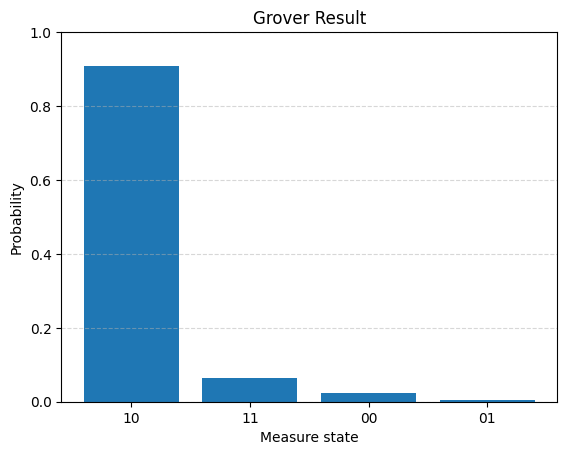

In [70]:
import matplotlib.pyplot as plt

plt.bar(x_axis, y_prob)
plt.title("Grover Result")
plt.xlabel("Measure state")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
